*주택 가격 예측하기*<br/>



설명 변수 [79개] <br/>
이 데이터를 바탕으로 모델 작성 후에 1459채 가격 예측<br/>
연속적인 값을 예측하는 회귀분석을 사용함.<br/>
RMSE = Root Mean Squared Error<br/>
RMSE를 사용할 때는 예측값과 실제 값 차이가 너무 큰 데이터가 포함되어 있으면 다른 예측값의 정확도가 아무리 좋아도 전체 예측 정확도가 크게 영향을 받음. <br/>
반면 실제 값 예측 값 각각에 로그를 취하면 각 데이터 간 차이가 작아져 특정 데이터가 전체 평가에 영향을 미치는 정도를 줄일 . 수있음.
예측 정확도를 확인할 때는 로그를 취해야 한다는 것을 잊지 맙시다.<br/>


In [145]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
plt.style.use("ggplot")

In [147]:
import pandas as pd
import numpy as np

In [148]:
import random
np.random.seed(1234)
random.seed(1234)
# random seed를 설정하는 이유 : 실험의 재현성을 위함.

In [149]:
train_df = pd.read_csv('./data_set/train.csv')
test_df = pd.read_csv('./data_set/test.csv')
submission = pd.read_csv('./data_set/sample_submission.csv')

In [150]:
train_df.shape

(1460, 81)

lightgbm으로 예측

각 변수의 중요도를 나타낼 수 있기 때문

In [151]:
train_df.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

In [152]:
train_df['MSZoning'].value_counts()

MSZoning
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64

In [153]:
# 전처리를 위해 train, test를 합친다.
all_df = pd.concat([train_df, test_df], sort=False).reset_index()

In [154]:
all_df

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,NaN
2915,1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,NaN
2916,1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,NaN
2917,1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,NaN


In [155]:
from sklearn.preprocessing import LabelEncoder

In [156]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [157]:
all_df["Alley"].value_counts()

Alley
Grvl    120
Pave     78
Name: count, dtype: int64

In [158]:
for cate in categories:
    le = LabelEncoder()
    print(cate)

    all_df[cate].fillna('missing', inplace=True) # 원본 데이터 프레임을 바꿀 것인지 말것인지를 설정할 수 있음.
    le = le.fit(all_df[cate])
    all_df[cate] = le.transform(all_df[cate])
    all_df[cate] = all_df[cate].astype("category") # 카테고리 변수임을 명시

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


In [159]:
all_df

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,0,1,60,3,65.0,8450,1,2,3,3,...,0,3,4,4,0,2,2008,8,4,208500.0
1,1,2,20,3,80.0,9600,1,2,3,3,...,0,3,4,4,0,5,2007,8,4,181500.0
2,2,3,60,3,68.0,11250,1,2,0,3,...,0,3,4,4,0,9,2008,8,4,223500.0
3,3,4,70,3,60.0,9550,1,2,0,3,...,0,3,4,4,0,2,2006,8,0,140000.0
4,4,5,60,3,84.0,14260,1,2,0,3,...,0,3,4,4,0,12,2008,8,4,250000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,1454,2915,160,4,21.0,1936,1,2,3,3,...,0,3,4,4,0,6,2006,8,4,NaN
2915,1455,2916,160,4,21.0,1894,1,2,3,3,...,0,3,4,4,0,4,2006,8,0,NaN
2916,1456,2917,20,3,160.0,20000,1,2,3,3,...,0,3,4,4,0,9,2006,8,0,NaN
2917,1457,2918,85,3,62.0,10441,1,2,3,3,...,0,3,2,2,700,7,2006,8,4,NaN


In [160]:
# 학습데이터와 테스트데이터로 되돌리기
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

In [161]:
# lightgbm으로 데이터 읽기
import lightgbm as lgb


In [162]:
# 교차검증용 라이브러리 설정
from sklearn.model_selection import KFold
folds = 3
kf = KFold(n_splits=folds)

In [163]:
# 하이퍼파리미터 설정
lgbm_params = {
    "objective" : "regression",
    "randome_seed" : 1234
}

In [164]:
# 설명 변수와 목적 변수 지정
train_X = train_df_le.drop(["SalePrice", "Id"], axis=1)
train_Y = train_df_le["SalePrice"]

In [165]:
# 평균 제곱 오차 라이브러리
from sklearn.metrics import mean_squared_error

In [166]:
# fold별로 작성한 모델을 models에 저장.
models = []
rmses = []
oof = np.zeros(len(train_X)) # 모든 요소가 0인 배열을 생성

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(
                            lgbm_params,
                            lgb_train,
                            valid_sets=lgb_eval
                          )
    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(np.log(y_valid), np.log(y_pred)))
    print(tmp_rmse)

    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 75
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Start training from score 179726.031860
0.12825706698915337
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the

In [167]:
sum(rmses)/len(rmses)
from statistics import mean
mean(rmses)

np.float64(0.13610045052556563)

In [168]:
# 현재 예측값과 실제 값 차이 확인하기
actual_pred_df = pd.DataFrame({
    "actual": train_Y,
    "pred": oof
})

<Axes: >

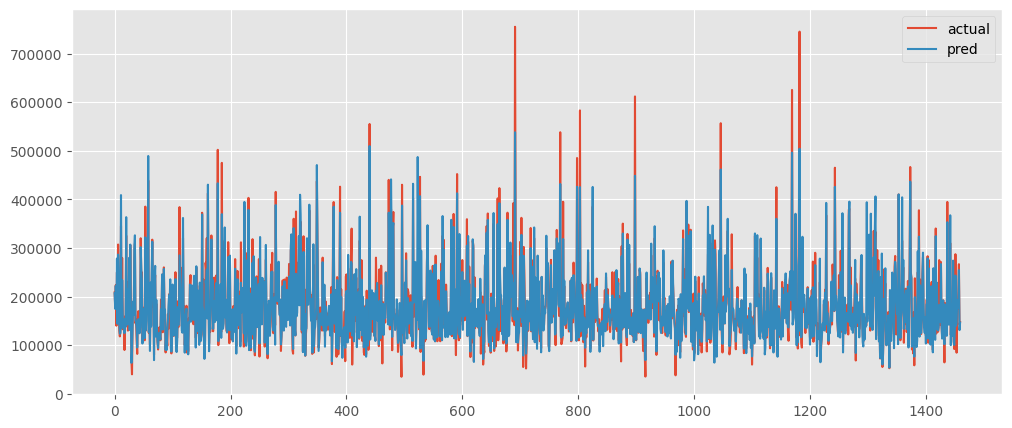

In [169]:
actual_pred_df.plot(figsize=(12,5))

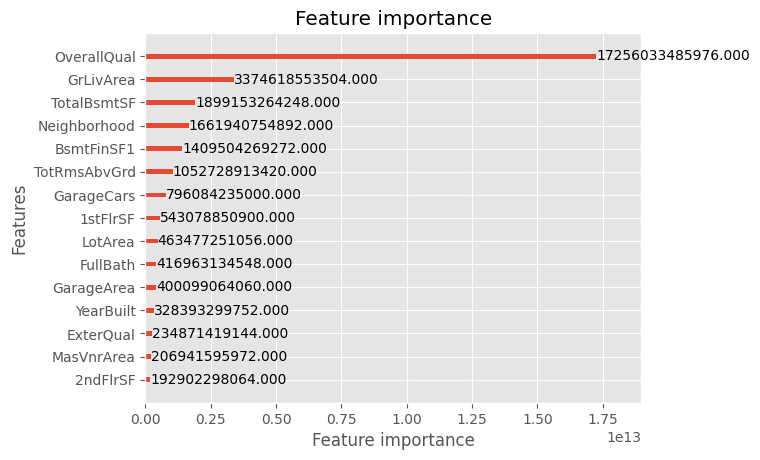

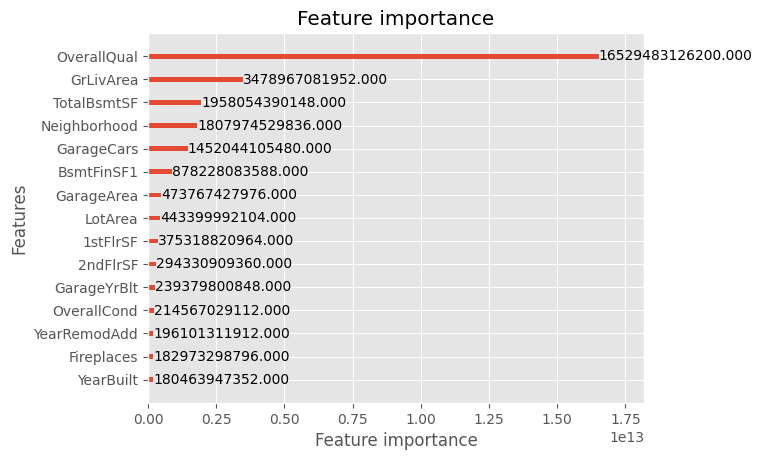

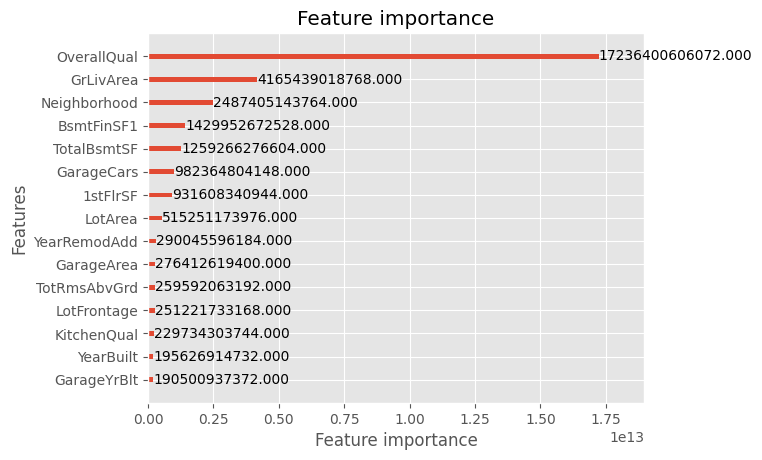

In [170]:
# 각 변수의 중요도 확인
for model in models:
    lgb.plot_importance(model, importance_type="gain", max_num_features=15)

In [171]:
# salesdata의 분표 확인
train_df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<Axes: ylabel='Frequency'>

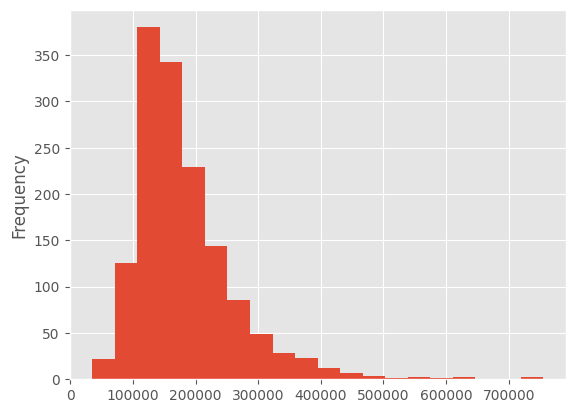

In [172]:
train_df['SalePrice'].plot.hist(bins=20)
# 정규 분포처럼 중앙값이 가장 빈도가 높고 좌우 대칭인 것이 아니라 왼쪽으로 치우쳐 있는 푸아송 분포를 그림.

<Axes: ylabel='Frequency'>

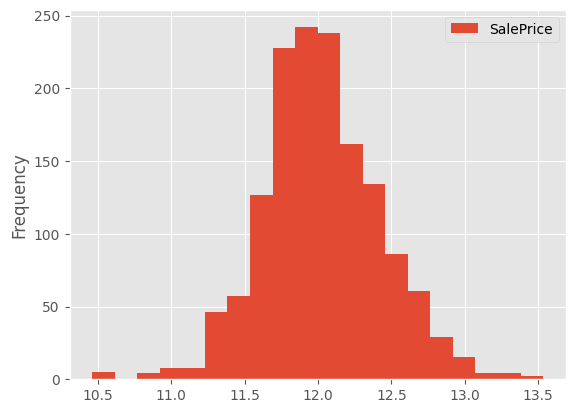

In [173]:
# 일반적으로 머신러이나 통계적인 처리의 대부분은 데이터가 정규분포임을 상정하고 있음.
# 16만달러의 영역을 좀 더 세밀하게 살펴볼 필요가 있음.
# 이 경진대회에서 평가 지표는 실제 값 로그와 예측값 로그의 RMSE가됨.

# 때문에 목적 변수를 로그화하는 편이 평가 지표를 최적화하기 쉬워짐.
pd.DataFrame(np.log(train_df['SalePrice'])).plot.hist(bins=20)

In [174]:
pd.options.mode.chained_assignment= None
train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])

In [175]:
import warnings
warnings.filterwarnings("ignore")

In [176]:
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis=1)
train_Y = train_df_le["SalePrice_log"]

In [177]:
models = []
rmse = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_Y.iloc[train_index]
    y_valid = train_Y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid , reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params,
        lgb_train,
        valid_sets=lgb_eval
    )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(tmp_rmse)

    models.append(model_lgb)
    rmse.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001540 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3218
[LightGBM] [Info] Number of data points in the train set: 973, number of used features: 75
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Start training from score 12.017607
0.1291800183199038
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3239
[LightGBM] [Info] Number of data points in the trai

In [178]:
# 각 설명 변수의 결측치 확인
all_df = pd.concat([train_df, test_df], sort=False).reset_index()

In [179]:
categories = all_df.columns[all_df.dtypes == "object"]
print(categories)

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')


In [180]:
all_df.isnull().sum().sort_values(ascending=False).head(40)

PoolQC           2909
MiscFeature      2814
Alley            2721
Fence            2348
MasVnrType       1766
SalePrice        1459
FireplaceQu      1420
LotFrontage       486
GarageQual        159
GarageCond        159
GarageYrBlt       159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrArea         23
MSZoning            4
BsmtHalfBath        2
Utilities           2
Functional          2
BsmtFullBath        2
Electrical          1
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
KitchenQual         1
Exterior2nd         1
GarageCars          1
Exterior1st         1
GarageArea          1
SaleType            1
Fireplaces          0
SaleCondition       0
KitchenAbvGr        0
YrSold              0
TotRmsAbvGrd        0
dtype: int64

In [181]:
all_df.PoolQC.value_counts()

PoolQC
Ex    4
Gd    4
Fa    2
Name: count, dtype: int64

In [182]:
# 90% 이상의 데이터가 결손된 PoolQC, MiscFeature, Alley 등 고급 주택 관련 설비는 대부분 값이 없음.
# 유무에 따라 값을 나누겠음.``
all_df.loc[~all_df['PoolQC'].isnull(), "PoolQC"] = 1
all_df.loc[all_df['PoolQC'].isnull(), "PoolQC"] = 0

In [183]:
all_df.PoolQC.value_counts()

PoolQC
0    2909
1      10
Name: count, dtype: int64

In [184]:
all_df.loc[~all_df['MiscFeature'].isnull(), "MiscFeature"] = 1
all_df.loc[all_df['MiscFeature'].isnull(), "MiscFeature"] = 0

all_df.loc[~all_df['Alley'].isnull(), "Alley"] = 1
all_df.loc[all_df['Alley'].isnull(), "Alley"] = 0

In [185]:
all_df["hasHighFacility"] = all_df['PoolQC'] + all_df['MiscFeature'] + all_df['Alley']

In [186]:
all_df["hasHighFacility"] = all_df["hasHighFacility"].astype(int)

In [187]:
all_df["hasHighFacility"].value_counts()

hasHighFacility
0    2615
1     295
2       9
Name: count, dtype: int64

In [188]:
all_df = all_df.drop(["PoolQC", "MiscFeature", "Alley"], axis = 1)

In [189]:
# 이상치 제외
all_df.describe()

,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,hasHighFacility
count,2919.000000,2919.000000,2919.000000,2433.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2896.000000,...,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,2919.000000,1460.000000,2919.000000
mean,729.250086,1460.000000,57.137718,69.305795,10168.114080,6.089072,5.564577,1971.312778,1984.264474,102.201312,...,47.486811,23.098321,2.602261,16.062350,2.251799,50.825968,6.213087,2007.792737,180921.195890,0.107229
std,421.393596,842.787043,42.517628,23.344905,7886.996359,1.409947,1.113131,30.291442,20.894344,179.334253,...,67.575493,64.244246,25.188169,56.184365,35.663946,567.402211,2.714762,1.314964,79442.502883,0.319268
min,0.000000,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000,0.000000
25%,364.500000,730.500000,20.000000,59.000000,7478.000000,5.000000,5.000000,1953.500000,1965.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000,129975.000000,0.000000
50%,729.000000,1460.000000,50.000000,68.000000,9453.000000,6.000000,5.000000,1973.000000,1993.000000,0.000000,...,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000,0.000000
75%,1094.000000,2189.500000,70.000000,80.000000,11570.000000,7.000000,6.000000,2001.000000,2004.000000,164.000000,...,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000,0.000000
max,1459.000000,2919.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,...,742.000000,1012.000000,508.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000,755000.000000,2.000000


In [190]:
train_df_num = train_df.select_dtypes(include = [np.number])
nonratio_features = ["Id", "MSSubClass", "OverallCond", "Yearbuild", "MoSold", "YrSold"]

In [191]:
num_features = sorted(list(set(train_df_num)-set(nonratio_features)))

In [192]:
train_df_num_rs = train_df_num[num_features]

In [193]:
for col in num_features:
    if train_df_num_rs.describe()[col]["75%"] == 0:
        print(col, len(train_df_num_rs[train_df_num_rs[col]==0]))
        

3SsnPorch 1436
BsmtFinSF2 1293
BsmtHalfBath 1378
EnclosedPorch 1252
LowQualFinSF 1434
MiscVal 1408
PoolArea 1453
ScreenPorch 1344


In [194]:
for col in num_features:
    if train_df_num_rs[col].nunique() < 15:
        print(col , train_df_num_rs[col].nunique())

BedroomAbvGr 8
BsmtFullBath 4
BsmtHalfBath 3
Fireplaces 4
FullBath 4
GarageCars 5
HalfBath 3
KitchenAbvGr 4
OverallQual 10
PoolArea 8
TotRmsAbvGrd 12


In [195]:
# 이상치가 있는지 확인하기
for col in num_features:
    tmp_df=train_df_num_rs[(train_df_num_rs[col] > train_df_num_rs[col].mean()+train_df_num_rs[col].std()*3) 
                           | (train_df_num_rs[col] < train_df_num_rs[col].mean()-train_df_num_rs[col].std()*3)]
    print(col, len(tmp_df))

1stFlrSF 12
2ndFlrSF 4
3SsnPorch 23
BedroomAbvGr 14
BsmtFinSF1 6
BsmtFinSF2 50
BsmtFullBath 16
BsmtHalfBath 82
BsmtUnfSF 11
EnclosedPorch 51
Fireplaces 5
FullBath 0
GarageArea 7
GarageCars 0
GarageYrBlt 1
GrLivArea 16
HalfBath 12
KitchenAbvGr 68
LotArea 13
LotFrontage 12
LowQualFinSF 20
MasVnrArea 32
MiscVal 8
OpenPorchSF 27
OverallQual 2
PoolArea 7
SalePrice 22
ScreenPorch 55
TotRmsAbvGrd 12
TotalBsmtSF 10
WoodDeckSF 22
YearBuilt 6
YearRemodAdd 0


<Axes: xlabel='BsmtFinSF1', ylabel='SalePrice'>

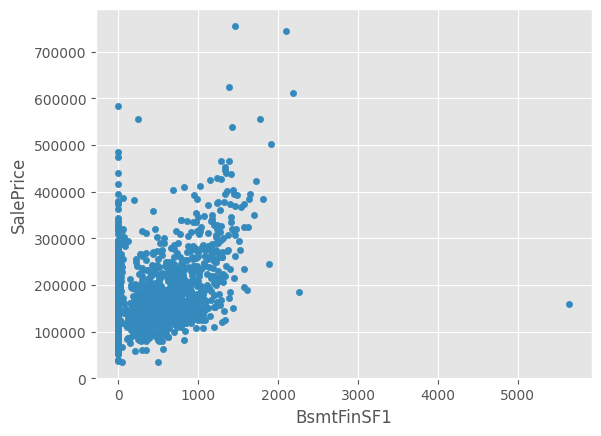

In [196]:
all_df.plot.scatter(x='BsmtFinSF1', y="SalePrice")

In [197]:
all_df[all_df["TotalBsmtSF"] > 5000]

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,1089,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

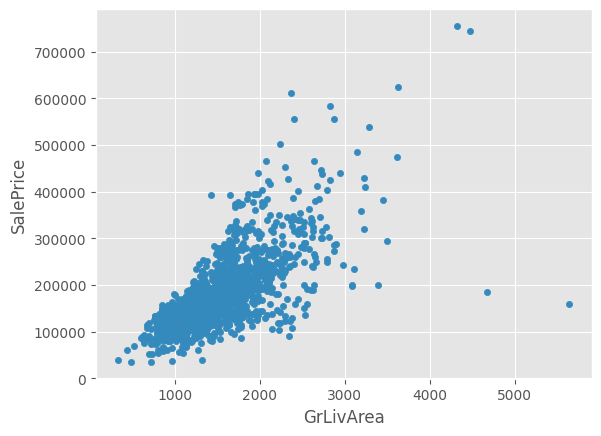

In [198]:
all_df.plot.scatter(x="GrLivArea", y="SalePrice")

In [199]:
all_df[all_df["GrLivArea"] > 5000]

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,1089,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


<Axes: xlabel='1stFlrSF', ylabel='SalePrice'>

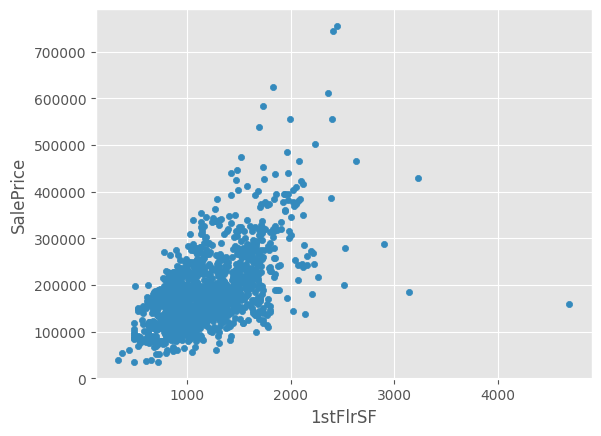

In [200]:
all_df.plot.scatter(x="1stFlrSF", y="SalePrice")

In [201]:
all_df[all_df["1stFlrSF"]> 4000]

,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,hasHighFacility
1298,1298,1299,60,RL,313.0,63887,Pave,IR3,Bnk,AllPub,...,0,480,NaN,0,1,2008,New,Partial,160000.0,1
2549,1089,2550,20,RL,128.0,39290,Pave,IR1,Bnk,AllPub,...,0,0,NaN,17000,10,2007,New,Partial,NaN,0


In [202]:
all_df = all_df[(all_df["BsmtFinSF1"] < 2000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df["TotalBsmtSF"] < 3000) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df["GrLivArea"] < 4500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df["1stFlrSF"] < 2500) | (all_df['SalePrice'].isnull())]
all_df = all_df[(all_df["LotArea"] < 100000) | (all_df['SalePrice'].isnull())]

In [203]:
categories = categories.drop(["PoolQC", "MiscFeature", "Alley"])

In [204]:
for cat in categories:
    le = LabelEncoder()
    print(cat)
    all_df[cat].fillna('missing', inplace=True)
    le = le.fit(all_df[cat])
    all_df[cat] = le.transform(all_df[cat])
    all_df[cat] = all_df[cat].astype('category')

MSZoning
Street
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
Fence
SaleType
SaleCondition


In [205]:
train_df_le = all_df[~all_df["SalePrice"].isnull()]
test_df_le = all_df[all_df["SalePrice"].isnull()]

train_df_le["SalePrice_log"] = np.log(train_df_le["SalePrice"])
train_X = train_df_le.drop(["SalePrice", "SalePrice_log", "Id"], axis = 1)
train_y = train_df_le["SalePrice_log"]

In [208]:
model = []
rmses = []
oof = np.zeros(len(train_X))

for train_index, val_index in kf.split(train_X):
    X_train = train_X.iloc[train_index]
    X_valid = train_X.iloc[val_index]
    y_train = train_y.iloc[train_index]
    y_valid = train_y.iloc[val_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    model_lgb = lgb.train(
        lgbm_params,
        lgb_train, 
        valid_sets = lgb_eval
    )

    y_pred = model_lgb.predict(X_valid, num_iteration=model_lgb.best_iteration)
    tmp_rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    models.append(model_lgb)
    rmses.append(tmp_rmse)
    oof[val_index] = y_pred

[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3203
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Start training from score 12.010615
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Warning] Unknown parameter: randome_seed
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001531 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3197
[LightGBM] [Info] Number of data points in the train set: 963, number of used features: 73
[LightGBM] [Warning] Unknown parameter: ran